In [14]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as ipt

###  Cut the required image size

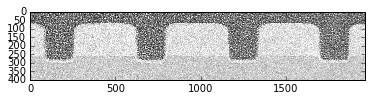

In [2]:
%matplotlib inline
image = cv2.imread('./AEI_G10_60K.tif')
image = image[260:660, :, :]
img = image[:, :, 0]
plt.imshow(img, cmap='gray')
plt.show()

### Define the blue and sobel functions

In [15]:
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # img = np.copy(image)
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #because this uses mpimg to read image
    gray = np.copy(image)
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'*1) + int(orient=='y'*0),int(orient=='x'*0) + int(orient=='y'*1))
    sobel = np.absolute(sobel)
    sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel >= thresh[0])&(sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # image = np.copy(img)
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.copy(img)
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = np.uint8(255*sobel/np.max(sobel))
    mag_binary = np.zeros_like(sobel_x)
    mag_binary[(sobel>=mag_thresh[0])&(sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # image = np.copy(img)
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.copy(img)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def sobel_filter(img, para):
    ksize = 5
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=para['grad_thresh'])
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=para['grad_thresh'])
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=para['mag_min'])
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=para['dir_thresh'])

    sobel_binary = np.zeros_like(gradx)
    sobel_binary[(gradx == 1) & (mag_binary == 1) & (mag_binary == 1)] = 1
    return sobel_binary


def interp_1d(arr):
    arr_f = ipt.interp1d(arr[:,0], arr[:,1], 'slinear')
    arr_x = np.r_[int(min(arr[:,0])):int(max(arr[:,0])):1]
    arr_y = arr_f(arr_x)
    return np.transpose(np.vstack((arr_x, arr_y)))
def plot_array(arr):
    plt.plot(arr[:, 0], arr[:, 1])
    plt.xlim(min(arr[:,0]), max(arr[:,0]))
    plt.ylim(min(arr[:,1])-10, max(arr[:,1])+10)
    plt.axes().set_aspect(1)

### Blur the image to reduce noise and apply different filters

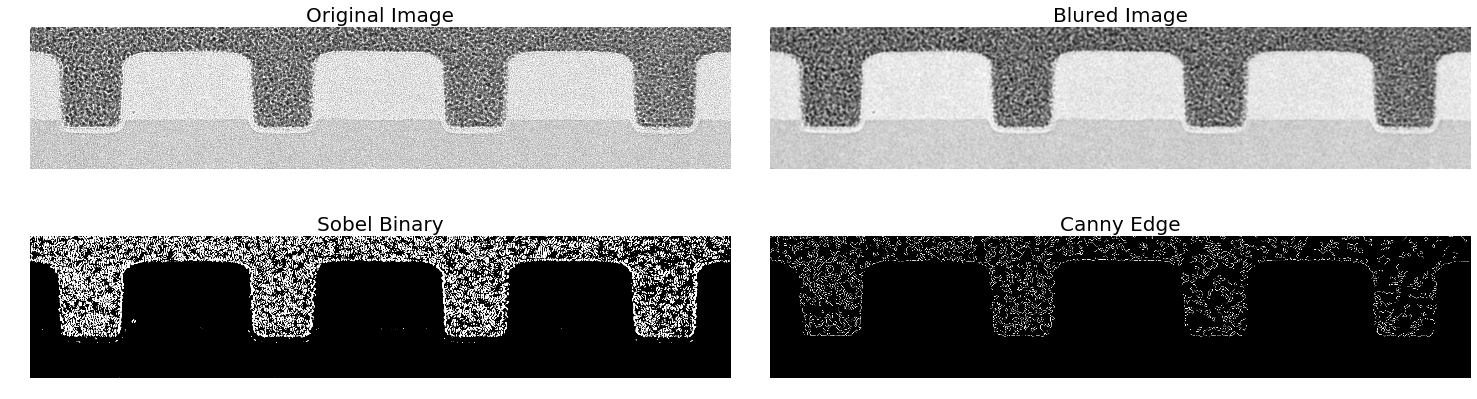

In [4]:
img_blur = gaussian_blur(img, 11)

para ={'grad_thresh': (20, 225),
       'mag_min': (60, 205),
       'dir_thresh':(0., np.pi/2)}
img_sobel = sobel_filter(img_blur, para)
img_canny = cv2.Canny(img_blur,80,200)

f, ax = plt.subplots(2, 2, figsize=(20, 6))
f.tight_layout()
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[0, 1].imshow(img_blur, cmap='gray')
ax[0, 1].set_title('Blured Image', fontsize=20)
ax[0, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 0].imshow(img_sobel, cmap='gray')
ax[1, 0].set_title('Sobel Binary', fontsize=20)
ax[1, 0].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 1].imshow(img_canny, cmap='gray')
ax[1, 1].set_title('Canny Edge', fontsize=20)
ax[1, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply threshold and filter

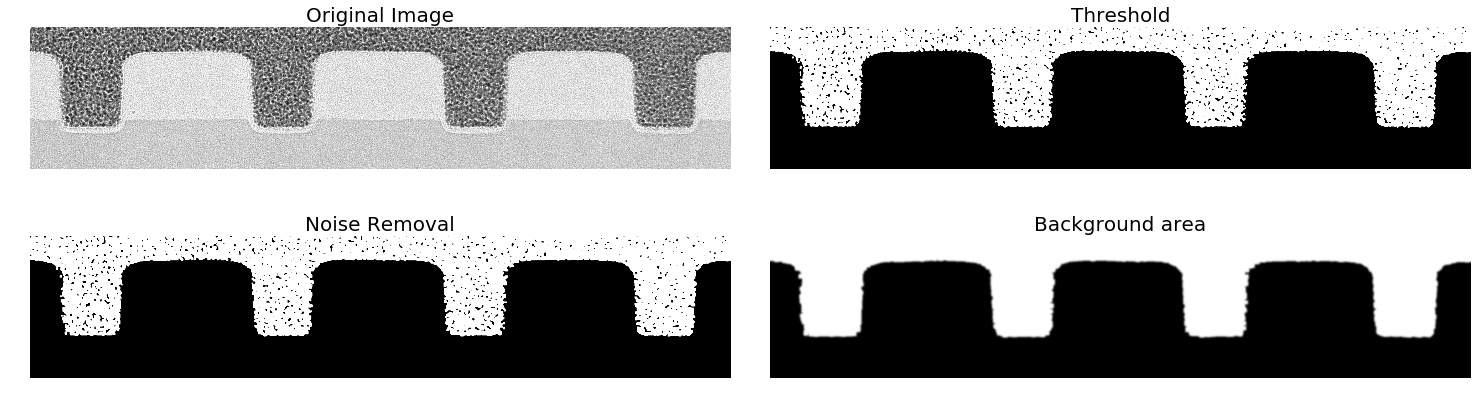

In [5]:
# apply threshold
ret, thresh = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
k_size = 3
kernel = np.ones((k_size,k_size),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

f, ax = plt.subplots(2, 2, figsize=(20, 6))
f.tight_layout()
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[0, 1].imshow(thresh, cmap='gray')
ax[0, 1].set_title('Threshold', fontsize=20)
ax[0, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 0].imshow(opening, cmap='gray')
ax[1, 0].set_title('Noise Removal', fontsize=20)
ax[1, 0].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 1].imshow(gaussian_blur(sure_bg, 15), cmap='gray')
ax[1, 1].set_title('Background area', fontsize=20)
ax[1, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply Sobel Again

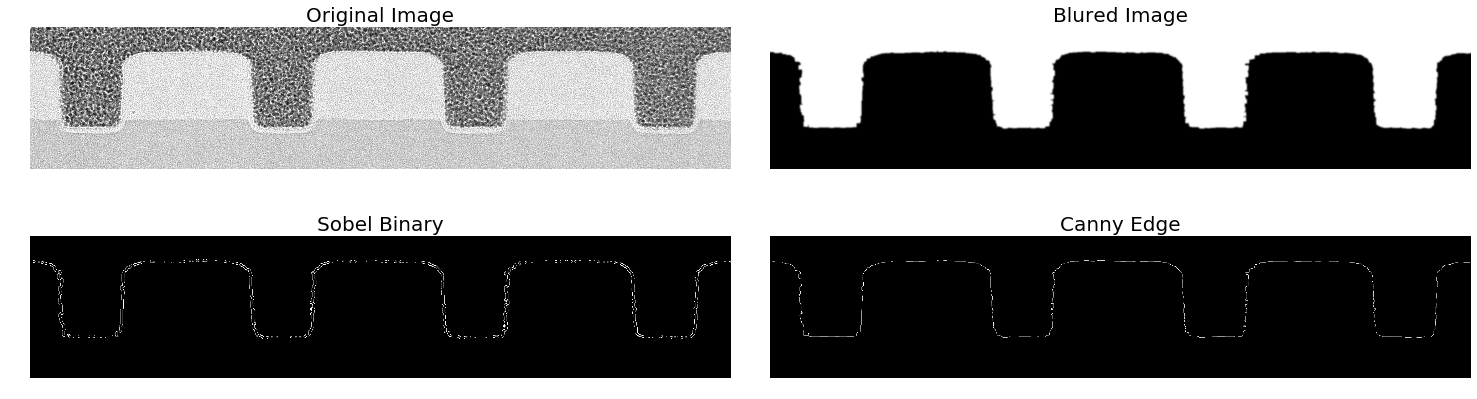

In [6]:
img_blur = gaussian_blur(sure_bg, 11)

para ={'grad_thresh': (20, 100),
       'mag_min': (60, 205),
       'dir_thresh':(0., np.pi/2)}
img_sobel = sobel_filter(img_blur, para)
edges = cv2.Canny(img_blur,5,10)

f, ax = plt.subplots(2, 2, figsize=(20, 6))
f.tight_layout()
ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Original Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[0, 1].imshow(img_blur, cmap='gray')
ax[0, 1].set_title('Blured Image', fontsize=20)
ax[0, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 0].imshow(img_sobel, cmap='gray')
ax[1, 0].set_title('Sobel Binary', fontsize=20)
ax[1, 0].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax[1, 1].imshow(edges, cmap='gray')
ax[1, 1].set_title('Canny Edge', fontsize=20)
ax[1, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
im2, contours, hierarchy = cv2.findContours(img_blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
len(contours)

1

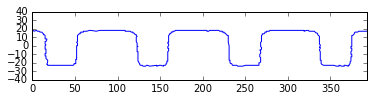

In [8]:
con = contours[0][1:-1,0]/5  # devide by 5 because of the TEM imaging 5pixs = 1nm
con[:, 1] = np.average(con[:, 1]) -con[:, 1]
plt.plot(con[:, 0], con[:, 1])
plt.xlim(0, max(con[:,0]))
plt.ylim(-40, 40)
plt.axes().set_aspect(1)

## Process Simulation Result

('The shape of simulation result is: ', '(474, 2)')
('The shape of experiment result is: ', '(483, 2)')


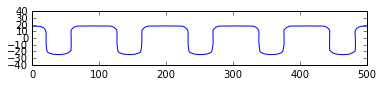

In [39]:
file = './sim_data/G10_sim6.csv'
sim = np.genfromtxt(file, delimiter=',')
sim[:, 0] -= sim[0, 0]
sim[:, 1] = sim[:, 1] - np.average(sim[:, 1])
print('The shape of simulation result is: ', format(sim.shape))
print('The shape of experiment result is: ', format(con.shape))
plt.plot(sim[:, 0], sim[:, 1])
plt.xlim(0, 500)
plt.ylim(-40, 40)
plt.axes().set_aspect(1)

### Interpolate the data

In [40]:
sim2 = interp_1d(sim)
con2 = interp_1d(con)
print("After interpolation, the shape of simulation is: ", format(sim2.shape))
print("After interpolation, the shape of experiment is: ", format(con2.shape))

('After interpolation, the shape of simulation is: ', '(500, 2)')
('After interpolation, the shape of experiment is: ', '(393, 2)')


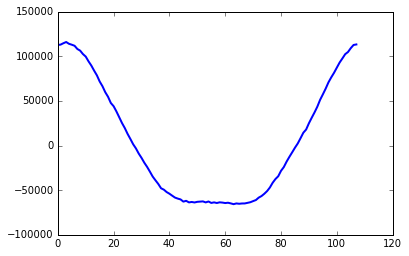

In [89]:
import scipy.signal as signal
res = signal.correlate(sim2[:,1], con2[:,1], 'valid')
plt.plot(res, linewidth=2)
shift = np.argmax(res)

('Score is: 115927.14', 'the x-shift is ', 3)


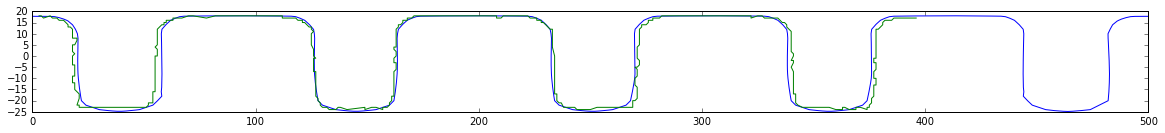

In [87]:
%matplotlib inline
plt.figure(figsize=(20, 4))
plt.plot(sim[:,0], sim[:,1])
plt.plot(con[:,0]+shift, con[:,1])
plt.axes().set_aspect(1)
print("Score is: %0.2f" %(res[shift]), "the x-shift is ", shift)

('The shape of experiment result is: ', '(483, 2)')
G10_sim1.csv
('Score is: 77330.33', 'the x-shift is ', 2)
G10_sim2.csv
('Score is: 96701.84', 'the x-shift is ', 107)
G10_sim3.csv
('Score is: 105162.54', 'the x-shift is ', 2)
G10_sim4.csv
('Score is: 105303.62', 'the x-shift is ', 2)
G10_sim5.csv
('Score is: 114241.80', 'the x-shift is ', 3)
G10_sim6.csv
('Score is: 115927.14', 'the x-shift is ', 3)


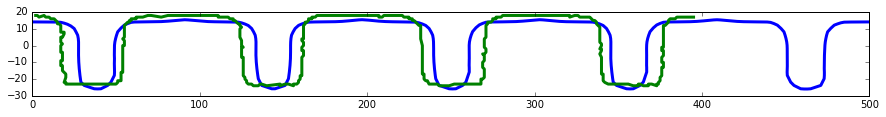

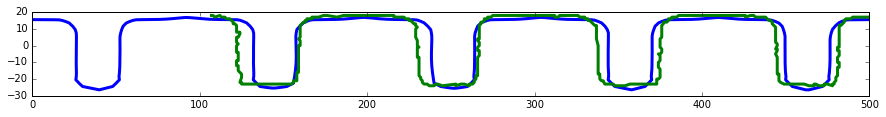

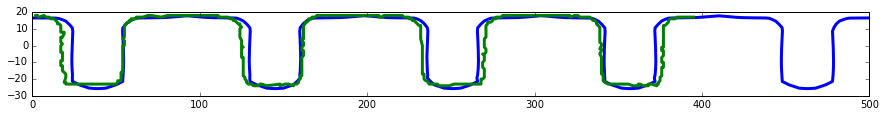

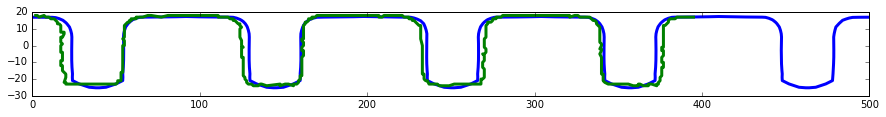

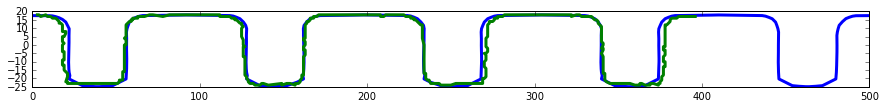

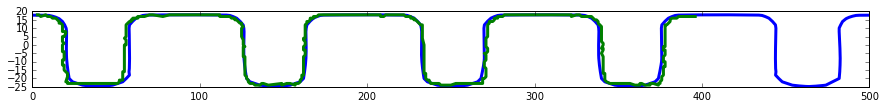

In [88]:
import os
print('The shape of experiment result is: ', format(con.shape))
folder = "./sim_data/"
final_score = []
# plt.figure(figsize=(20, 4))
for file in sorted(os.listdir(folder)):
    if file.endswith(".csv"):
        print(file)
        sim = np.genfromtxt(folder+file, delimiter=',')
        sim[:, 0] -= sim[0, 0]
        sim[:, 1] = sim[:, 1] - np.average(sim[:, 1])
        sim2 = interp_1d(sim)
        res = signal.correlate(sim2[:,1], con2[:,1], 'valid')
        shift = np.argmax(res)
        plt.figure(figsize=(15, 4))
        plt.plot(sim[:,0], sim[:,1], linewidth=3)
        plt.plot(con[:,0]+shift, con[:,1], linewidth=3)
        plt.axes().set_aspect(1)
        print("Score is: %0.2f" %(res[shift]), "the x-shift is ", shift)
        final_score.append(res[shift])

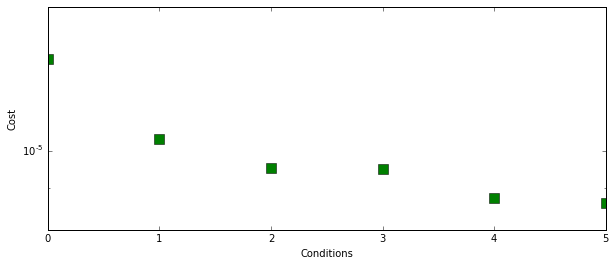

In [80]:
plt.figure(figsize=(10, 4))
plt.plot(np.divide(1, final_score), 'sg', ms=10)
plt.yscale('log')
# plt.ylim(min(final_score)-1000, max(final_score)+1000)
plt.ylim(8e-6, 1.5e-5)
plt.xlabel('Conditions')
plt.ylabel('Cost')

In [ ]:
res = cv2.matchTemplate(sim2, con2, cv2.TM_CCOEFF_NORMED)

In [ ]:
res = signal.correlate(sim, con, mode='valid', method = 'fft')
plt.plot(res)

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot([0,1,2], [10,20,3])
fig.savefig('./to.png')   # save the figure to file
plt.close(fig)    # close the figure

In [ ]:
%matplotlib qt
plt.plot(sim2[:,0], sim2[:,1])
plt.plot(con2[:,0]+23, con2[:,1])

In [90]:
import matlab.engine

ImportError: No module named matlab.engine